**Виявлення рухомих об'єктів на відео**

У цьому блокноті ми продемонструємо методи виявлення рухомих об’єктів на відео з камери відеоспостереження. Камера буде у фіксованому положенні і не рухається.

Ми зробимо наступне:

1. Оцініть фон із медіанною фіксацією
2. Покажіть, як видалити фон із малюнка
3. Прийоми розмиття та порогів
4. Виявлення countours
5. Реалізація вищевказаного процесу на відео

# Import libraries

In [57]:
import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt

np.random.seed(42)

Визначте процедуру для вирішення проблеми з кольором, щоб переконатися, що кольори правильно бачать у matplotlib

In [58]:
#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


## Input

In [59]:
#Take a look at the input video
from IPython.display import Video
#Video("images/overpass.mp4", embed=True)

#Replace with your own video

# Витягніть фон у відео.

Ми визначаємо фон, який нам доведеться використовувати для фільтрації. Простий спосіб зробити це – взяти кілька випадкових кадрів із відео та знайти його медіану. Ми робимо це, знаходячи медіану кожного пікселя. Це спрацьовує, оскільки в більшості випадків через дорогу не проїжджає жодний транспортний засіб. Медіана завершить фільтрацію всіх рухомих об’єктів у відео.

Зауважте, що це працює, якщо камера нерухома і не рухається.

У розділі ми фіксуємо відео у відеопотік і отримуємо 30 випадкових кадрів. Ці кадри зберігаються в масиві кадрів

In [60]:
video_stream = cv2.VideoCapture('images/highway.mp4')

# Randomly select 30 frames
frameIds = video_stream.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=30)

# Store selected frames in an array
frames = []
for fid in frameIds:
    video_stream.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = video_stream.read()
    frames.append(frame)
    
video_stream.release()


Тепер ми обчислимо середній і середній кадри для збережених кадрів. Ми будемо використовувати медіану, оскільки вона краще видаляє викиди.

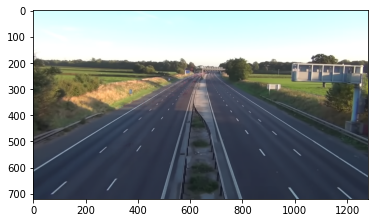

In [61]:
# Calculate the median along the time axis
medianFrame = np.median(frames, axis=0).astype(dtype=np.uint8)
plt.imshow(fixColor(medianFrame))

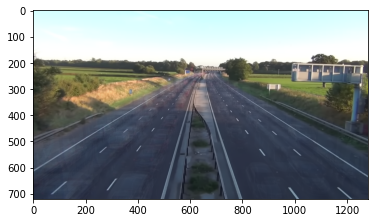

In [62]:
# Calculate the average along the time axis
avgFrame = np.average(frames, axis=0).astype(dtype=np.uint8)
plt.imshow(fixColor(avgFrame))

# Обробка кадру

Зараз ми покажемо, як обробити одну фотографію, пояснимо всі необхідні кроки. Ми візьмемо перший кадр із нашого масиву фреймів. На фото ми бачимо кілька автомобілів.

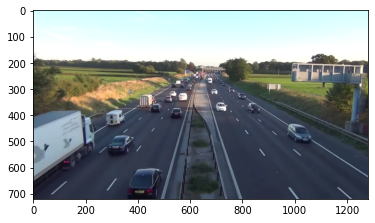

In [63]:
sample_frame=frames[0]
plt.imshow(fixColor(sample_frame))

Для ідентифікації рухомих об’єктів краще працювати з зображеннями у відтінках сірого. Ми перетворимо як серединне зображення, так і зразок зображення у відтінки сірого

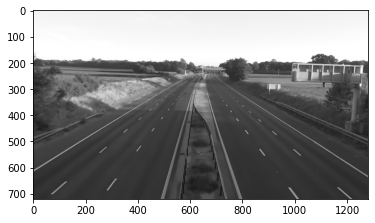

In [64]:
grayMedianFrame = cv2.cvtColor(medianFrame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(grayMedianFrame))

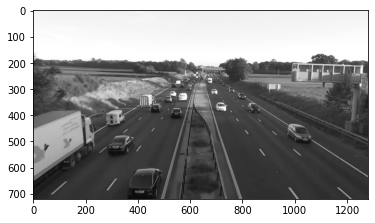

In [65]:
graySample=cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(graySample))

## Видалити фон
Видаліть фон з нашого зразка. Тепер ми бачимо примарне зображення з автомобілями та видаленими фоном.

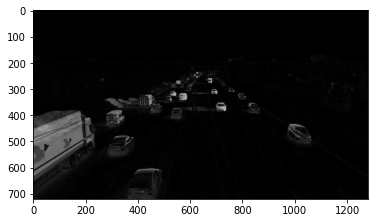

In [66]:
dframe = cv2.absdiff(graySample, grayMedianFrame)
plt.imshow(fixColor(dframe))

## Розмивання

Ми запустимо розмивання за Гауссом, щоб зменшити шум і полегшити ідентифікацію країв

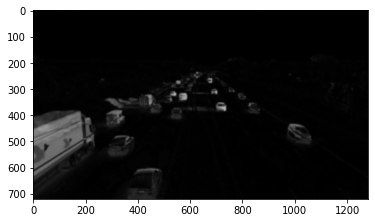

In [67]:
blurred = cv2.GaussianBlur(dframe, (11,11), 0)
plt.imshow(fixColor(blurred))

## Порогове значення

Тепер ми запустимо поріг, щоб очистити виведення об’єктів, що залишилися тут. Ми будемо використовувати порогове значення OTSU, яке автоматично визначає правильні порогові рівні.

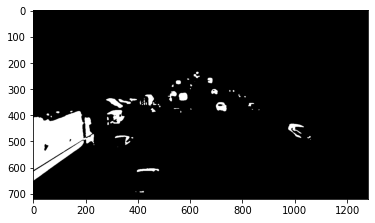

In [68]:
ret, tframe= cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(fixColor(tframe))

## Контурні та обмежувальні квадрати

Створюємо контури за допомогою порогових картинок

In [69]:
(cnts, _) = cv2.findContours(tframe.copy(), cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE)

Тепер ми створимо обмежувальні рамки для визначених контурів і покажемо їх на наших зразках зображень. Ми не будемо брати до уваги такі елементи, як рухомі хмари у верхній частині нашого зображення

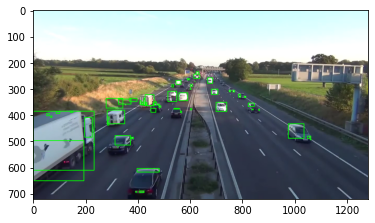

In [70]:
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    if y > 200:  #Disregard item that are the top of the picture
        cv2.rectangle(sample_frame,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(fixColor(sample_frame))

# Збірка для обробки відео# Putting in together for processing video

Спочатку ми оголошуємо вихідне відео, яке буде створено. Ми використовуємо вбудований CV2 для створення відео MP4 із 30 кадрами в секунду та розміром кадру 640*480

In [71]:
writer = cv2.VideoWriter("output.mp4", 
                         cv2.VideoWriter_fourcc(*"MP4V"), 30,(640,480))

In [72]:
#Create a new video stream and get total frame count
video_stream = cv2.VideoCapture('images/highway.mp4')
total_frames=video_stream.get(cv2.CAP_PROP_FRAME_COUNT)
total_frames

1526.0

In [73]:


frameCnt=0
while(frameCnt < total_frames-1):

    frameCnt+=1
    ret, frame = video_stream.read()

    # Convert current frame to grayscale
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate absolute difference of current frame and
    # the median frame
    dframe = cv2.absdiff(gframe, grayMedianFrame)
    # Gaussian
    blurred = cv2.GaussianBlur(dframe, (11, 11), 0)
    #Thresholding to binarise
    ret, tframe= cv2.threshold(blurred,0,255,
                               cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #Identifying contours from the threshold
    (cnts, _) = cv2.findContours(tframe.copy(), 
                                 cv2.RETR_EXTERNAL, cv2 .CHAIN_APPROX_SIMPLE)
    #For each contour draw the bounding bos
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        if y > 200: # Disregard items in the top of the picture
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    writer.write(cv2.resize(frame, (640,480)))
 
#Release video object
video_stream.release()
writer.release()
